In [2]:
import numpy as np

In [3]:
labels_path = "../data/labels/"
imgs_path = "../data/sat_imgs/"

In [4]:
label = np.load(labels_path + "/99.npy")
img = np.load(imgs_path + "/99.npy")

In [5]:
label.shape

(1, 523, 499)

In [6]:
img_rgb = img[..., [2,1,0]]

In [7]:
img_rgb.shape

(523, 499, 3)

In [8]:
mask = np.where(label >= 35, 1, 0)

In [9]:
m = np.reshape(mask, (mask.shape[1], mask.shape[2], 1))

In [10]:
import matplotlib.pyplot as plt

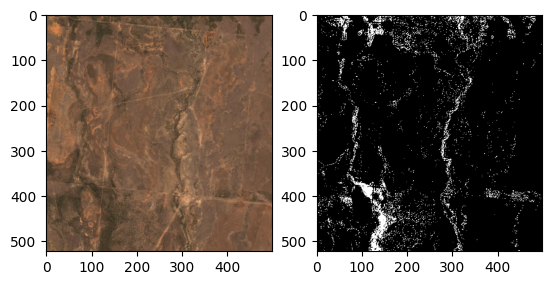

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img_rgb * 3)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(m, cmap = 'gray')

In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from scipy.ndimage import zoom
from tqdm import tqdm
import os
import re


In [52]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [74]:
class CustomDataset(Dataset):
    def __init__(self, image_files, labels_folder, target_size = (512, 512), transform=None):
        self.image_files = image_files
        self.labels_folder = labels_folder
        self.transform = transform
        self.target_size = target_size
#         self.image_files = os.listdir(images_folder)
#         self.label_files = os.listdir(labels_folder)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):

        image_path = self.image_files[idx]
        match = re.search(r'(\d+)', image_path)
        
        data_id = match.group(1)
        label_path = os.path.join(self.labels_folder, data_id + '.npy')

        image = np.load(image_path)
        label = np.load(label_path)
        mask = np.where(label >= 35, 1, 0)
        mask = np.reshape(mask, (mask.shape[1], mask.shape[2], 1))
        
        image = self.interpolate(image, self.target_size)
        mask = self.interpolate(mask, self.target_size)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask
    
    def interpolate(self, array, target_size):
        zoom_factors = [target_size[i] / array.shape[i] for i in range(2)]
        zoom_factors.append(1)
        
        interpolated_array = zoom(array, zoom_factors, order=1, mode='nearest')

        return interpolated_array


In [75]:
images_folder = "../data/sat_imgs/"
labels_folder = "../data/labels/"

In [76]:
image_files = os.listdir(images_folder)
image_files = [os.path.join(images_folder, file) for file in image_files]
train_files, test_files = train_test_split(image_files, test_size=0.3, random_state=42)

In [77]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = CustomDataset(train_files, labels_folder, transform=transform)
test_dataset = CustomDataset(test_files, labels_folder, transform=transform)

In [78]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [72]:

for batch in train_loader:
    tmp_img = batch[0]
    tmp_mask = batch[1]
    break

(523, 499, 1) (523, 499, 11)
(512, 512, 1) (512, 512, 11)


In [83]:
in_channels = 11  
out_channels = 1  
model = UNet(in_channels, out_channels)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)

UNet(
  (encoder): Sequential(
    (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Upsample(scale_factor=2.0, mode=bilinear)
  )
)

In [86]:
for epoch in range(epochs):
    model.train()
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)
        
        outputs = model(images)
        masks = masks.float()
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.float()
            outputs = model(images)
            total_loss += criterion(outputs, masks).item()

    avg_loss = total_loss / len(test_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_loss}")

torch.save(model.state_dict(), 'unet_model.pth')

Epoch 1/1: 100%|████████████████████████████████████████████████████████████████████████| 70/70 [00:40<00:00,  1.73it/s]


Epoch [1/1], Validation Loss: 0.6931472420692444
